In [1]:
#!pip install obspy

In [2]:
# Import modules
import string
import time
import argparse as ap
import sys
import os
import glob

import numpy as np
import pandas as pd
import obspy.core as oc
from obspy.signal.trigger import trigger_onset
from obspy.core.utcdatetime import UTCDateTime

import matplotlib.pyplot as plt

import math # for pi, sqrt, etc

import tensorflow as tf # version 2
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import losses

import h5py
import json

import random

import scipy.stats as stats
import scipy.signal as signal

from datetime import datetime

In [3]:
# Define function to produce sliding windows of signal (from original GPD GitHub repo https://github.com/interseismic/generalized-phase-detection/blob/master/gpd_predict.py)

def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided

In [4]:
!git clone https://github.com/tesfahiwet-yemane/U-GPD.git

fatal: destination path 'U-GPD' already exists and is not an empty directory.


In [5]:
# Load model and weights
model = load_model('./U-GPD/model/best/ugpd_tf2', compile=False)
print("*** U-GPD MODEL AND WEIGHTS LOADED FROM DISK ***")

Metal device set to: Apple M2


2023-04-07 14:31:49.190525: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-07 14:31:49.191095: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


*** U-GPD MODEL AND WEIGHTS LOADED FROM DISK ***


In [6]:
# #### UNCOMMENT THIS CELL TO DOWNLOAD NABRO DATA FROM IRIS ####

# # Give start and end time to extract data
# station = "NAB*"
# day = "2011-09-26"
# starttime = UTCDateTime(day + "T00:00:00")
# endtime = UTCDateTime(day + "T23:59:59.999999")

# # Get waveforms for network 4H on this day and save as mseed (seems to be a little quicker than using the obspy client to request data)
# before = datetime.now()
# os.system("wget -O nabro_2011-247.mseed http://service.iris.edu/fdsnws/dataselect/1/query?net=4H\&sta=" + station + "\&loc=*\&cha=HH?\&start=" + str(starttime)[0:-1] + "\&end=" + str(endtime)[0:-1])
# after = datetime.now()
# print(after-before)

In [7]:
#### ALTERNATIVELY, THIS CELL DOWNLOADS DATA DIRECTLY FROM ACHIVED ZENODO REPOSITORY ####
from obspy import read
# This file file is approx 640 MB so takes a few minutes to download...
before = datetime.now()
#os.system("wget -O fdsnws-dataselect_2023-02-25t10_50_24z.mseed https://sandbox.zenodo.org/record/1167927/files/fdsnws-dataselect_2023-02-25t10_50_24z.mseed?download=1 --show-progress")
st = read("/Users/tesfahiwetyemane/Downloads/fdsnws-dataselect_2023-03-28t20_18_58z.mseed")
after = datetime.now()
print(after-before)

0:00:02.048439


In [8]:

#### UNCOMMENT THIS CELL IF DOWNLOADED NABRO DATA USING ABOVE ####
import glob
files = glob.glob("/Users/tesfahiwetyemane/Downloads/fdsnws-dataselect_2023-03-28t20_18_58z.mseed") # List files

In [9]:
# Load waveforms into obspy
st = oc.Stream()
for f in np.arange(0, len(files)):
    st += oc.read(files[f])
st.sort()
#st.detrend()
#st.detrend('demean')
#st.filter('bandpass', freqmin=2, freqmax=15, corners=4, zerophase=True)
st.merge(method=0, fill_value=0)
            
stations = list(set([st[s].stats.station for s in np.arange(0, len(st))]))

In [10]:
print(st)

33 Trace(s) in Stream:

XM.A02E..HHE | 2012-12-20T00:00:00.000000Z - 2012-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples
...
(31 other traces)
...
XM.A13E..HHZ | 2012-12-20T00:00:00.000000Z - 2012-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


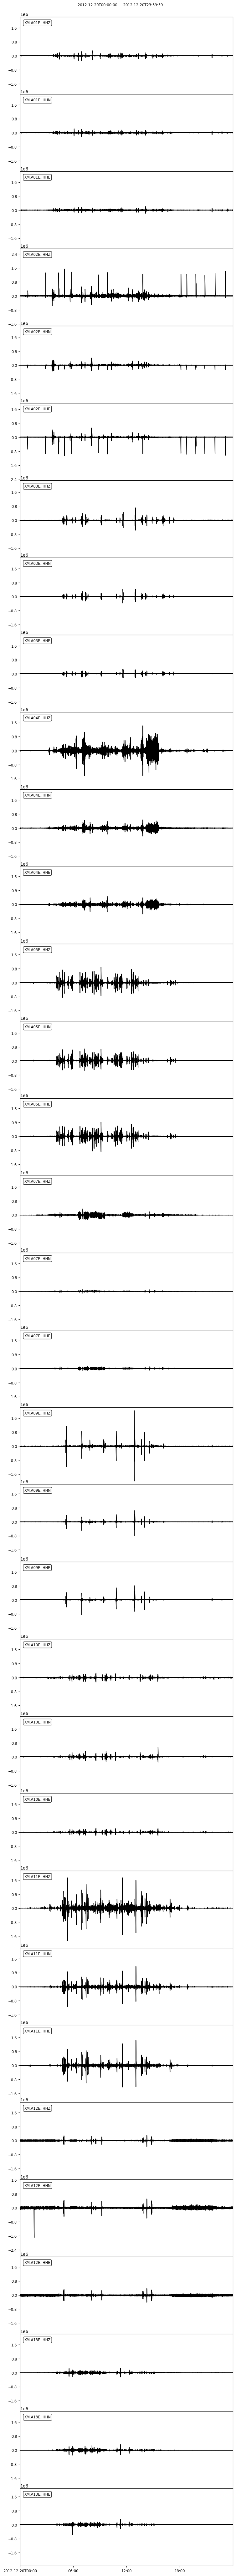

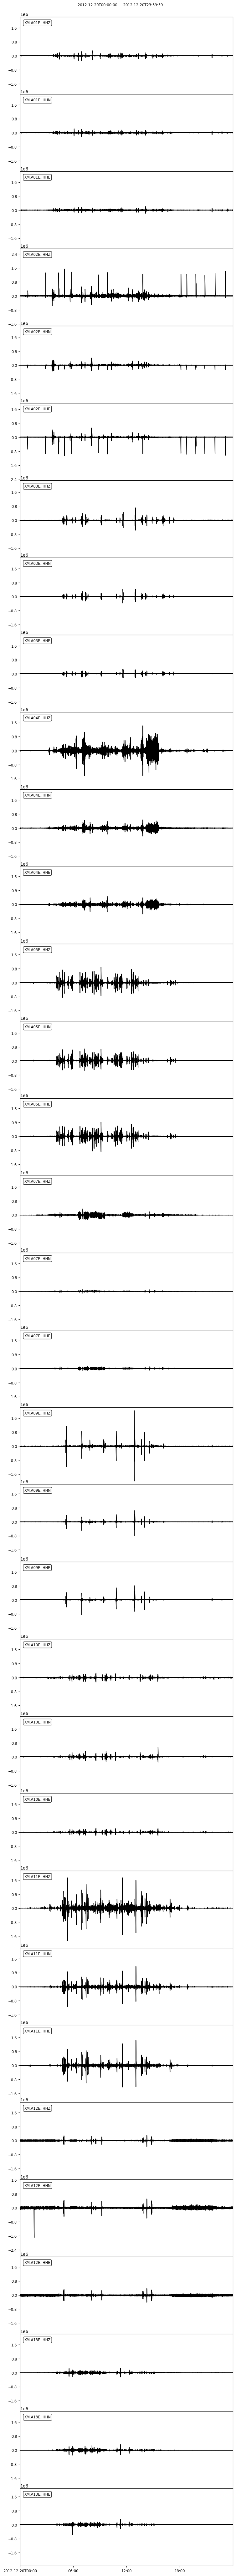

In [11]:
st.plot()

In [12]:
# Model prediction parameters
shift_size = 200 # Overlap (in samples) for sliding window
batch_size = 100 # No. of windows to process at a time

# Trigger parameters
p_thresh = 0.4 # Trigger on threshold for P-waves
s_thresh = 0.4 # Trigger on threshold for S-waves
trig_off = 0.2 # Trigerr off threshold for both phase arrivals

In [13]:
# List available stations
stations = list(set([st[s].stats.station for s in np.arange(0, len(st))]))

# Dataframe to store picks from trigger
df = pd.DataFrame(columns=['time', 'sta', 'pha', 'prob'])

# Empty obspy stream to store prediction traces
st_pred = oc.Stream()

# Loop through list of available stations
before = datetime.now() # Get time before and after to see how long this takes
for s in np.arange(0, len(stations)):

    st2 = st.copy().select(station=stations[s])
    
    # If there are data gaps (i.e., more than 3 traces per station) then merge the traces together
    no_of_traces_per_station = st2.count() / 3
    
    if no_of_traces_per_station > 1:
        st2.merge(method=0, fill_value=0)
    
    # Trim to same length:
    latest_start = np.max([x.stats.starttime for x in st2])
    earliest_stop = np.min([x.stats.endtime for x in st2])
    st2.trim(latest_start, earliest_stop)        
    
    # Expand overlapping windows using sliding_window function
    sliding_E = sliding_window(st2[0].data, 400, stepsize=shift_size) # Slide window across first component
    tr_win = np.zeros((sliding_E.shape[0], 400, 3)) # 3D array (of zeros)
    tr_win[:,:,0] = sliding_E # Add to 3D array
    sliding_E = None # clear some memory
    
    sliding_N = sliding_window(st2[1].data, 400, stepsize=shift_size) # Slide window across second component
    tr_win[:,:,1] = sliding_N # Add to 3D array
    sliding_N = None # clear some memory
    
    sliding_Z = sliding_window(st2[2].data, 400, stepsize=shift_size) # Slide window across third component
    tr_win[:,:,2] = sliding_Z # Add to 3D array
    sliding_Z = None # clear some memory
    
    tr_win = signal.detrend(tr_win, axis=1) # Detrend 
    tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)
    
    # Model prediction step...
    ts = model.predict(tr_win, verbose=True, batch_size=batch_size)
    
    # Merge overlapping predictions:
    n_steps_per_win = 400/shift_size # No. of steps per window (i.e. how many overlapping windows)
    class_trace = np.zeros((len(st2[0].data), int(3))) # Create prediction traces to be same size as input data
    for i in np.arange(0, ts.shape[0]): # For each window
        class_trace[((i * shift_size) + 100):((i * shift_size) + 300), :] += ts[i, 100:300, :] # Keep middle 200 predictions
    
    # Create obspy stream for P-pick prediction trace
    p_trace = oc.Trace()
    p_stream = oc.Stream()
    p_stream += p_trace
    p_stream[0].data = class_trace[:,0]
    p_stream[0].stats = st2.copy()[0].stats
    p_stream[0].stats.channel = "P"

    # Create obspy stream for S-pick prediction trace
    s_trace = oc.Trace()
    s_stream = oc.Stream()
    s_stream += s_trace
    s_stream[0].data = class_trace[:,1]
    s_stream[0].stats = st2.copy()[1].stats
    s_stream[0].stats.channel = "S"

    # Add them to st_pred obspy stream
    st_pred += p_stream
    st_pred += s_stream

    # Use obspy trigger to find predictions above threshold (i.e. p_thresh and s_thresh)
    # P-wave picks (trigger):
    trigs = trigger_onset(class_trace[:,0], p_thresh, trig_off) # Look for triggers (prediction trace exceeding p_thresh)
    p_picks = []
    p_probs = []
    for trig in trigs:
        if trig[1] == trig[0]:
            continue # If trigger on and off times are the same then ignore
        pick = np.argmax(class_trace[trig[0]:trig[1], 0]) + trig[0] # Use argmax between trigger on and off times as pick time
        stamp_pick = st2[0].stats.starttime + (pick * st2[0].stats.delta) # Pick time as UTCDateTime
        p_picks.append(stamp_pick) # Append time to list of P pick times
        p_probs.append(class_trace[pick, 0]) # Append prob to list of P pick probabilities
    # Add picks to df for this day            
    if len(p_picks) > 0:
        df_add = pd.DataFrame(p_picks, columns=['time'])
        df_add['sta'] = stations[s]
        df_add['pha'] = 'p'
        df_add['prob'] = p_probs
        df = pd.concat([df, df_add])
        
    # Repeat above for S-wave picks and s_thresh:
    trigs = trigger_onset(class_trace[:,1], s_thresh, trig_off)
    s_picks = []
    s_probs = []
    for trig in trigs:
        if trig[1] == trig[0]:
            continue
        pick = np.argmax(class_trace[trig[0]:trig[1], 1]) + trig[0]
        stamp_pick = st2[0].stats.starttime + (pick * st2[0].stats.delta)
        s_picks.append(stamp_pick)
        s_probs.append(class_trace[pick, 1])
    # Add picks to df for this day
    if len(s_picks) > 0:
        df_add = pd.DataFrame(s_picks, columns=['time'])
        df_add['sta'] = stations[s]
        df_add['pha'] = 's'
        df_add['prob'] = s_probs
        df = pd.concat([df, df_add])

df = df.sort_values(by='time').reset_index(drop=True) # Sort df by pick times
#df.to_pickle("trigs.pkl") # Write df to pkl file - uncomment if you want to save your model picks

after = datetime.now()
time_taken = after-before
print("24 hours data from " + str(len(stations)) + " stations processed in " + str(time_taken.seconds) + "." + str(time_taken.microseconds) + " seconds.")    


2023-04-07 14:35:17.723196: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-07 14:35:17.867726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


432/432 [==============================] - 14s 32ms/step


/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/1162276924.py:42: RuntimeWarning: invalid value encountered in divide
  tr_win = tr_win / np.max(np.abs(tr_win), axis=(1,2))[:,None,None] # Normalize between 0 and 1 (divide by max across 3 components for each window)


432/432 [==============================] - 14s 31ms/step
24 hours data from 11 stations processed in 186.503155 seconds.


In [14]:
st_pred

22 Trace(s) in Stream:

XM.A07E..P | 2012-12-20T00:00:00.000000Z - 2012-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples
...
(20 other traces)
...
XM.A02E..S | 2012-12-20T00:00:00.000000Z - 2012-12-20T23:59:59.000000Z | 100.0 Hz, 8639901 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

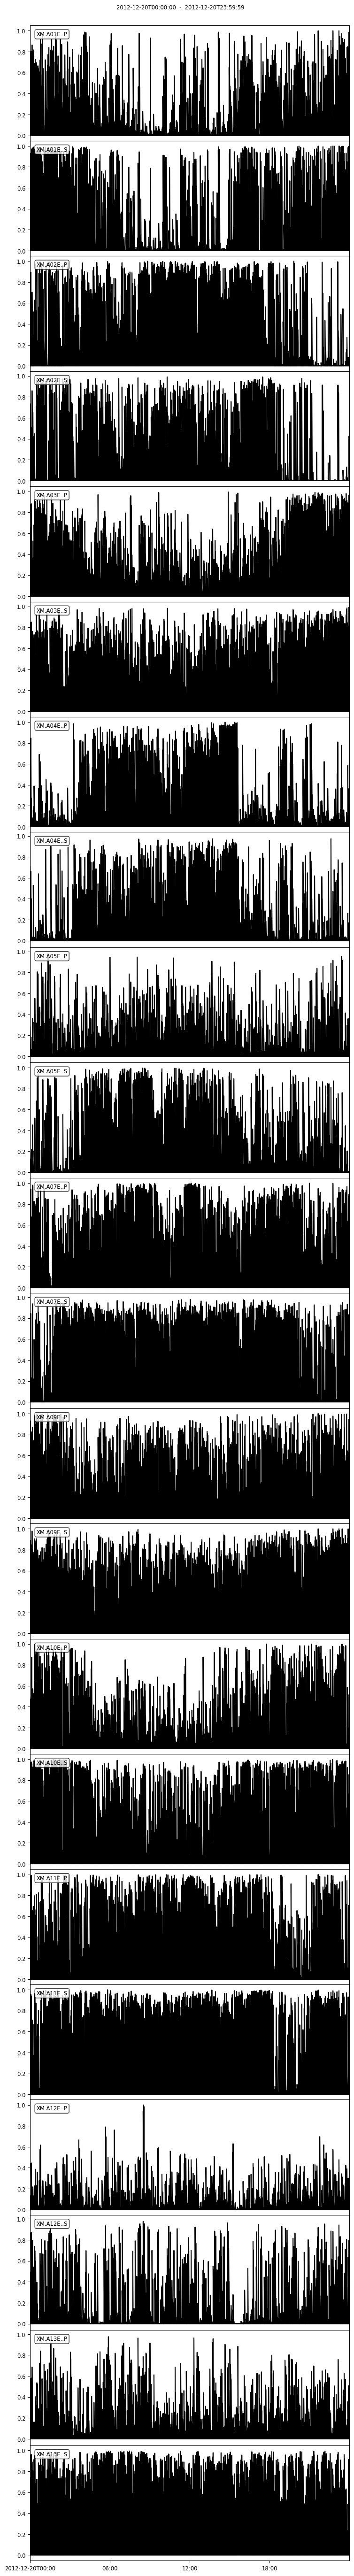

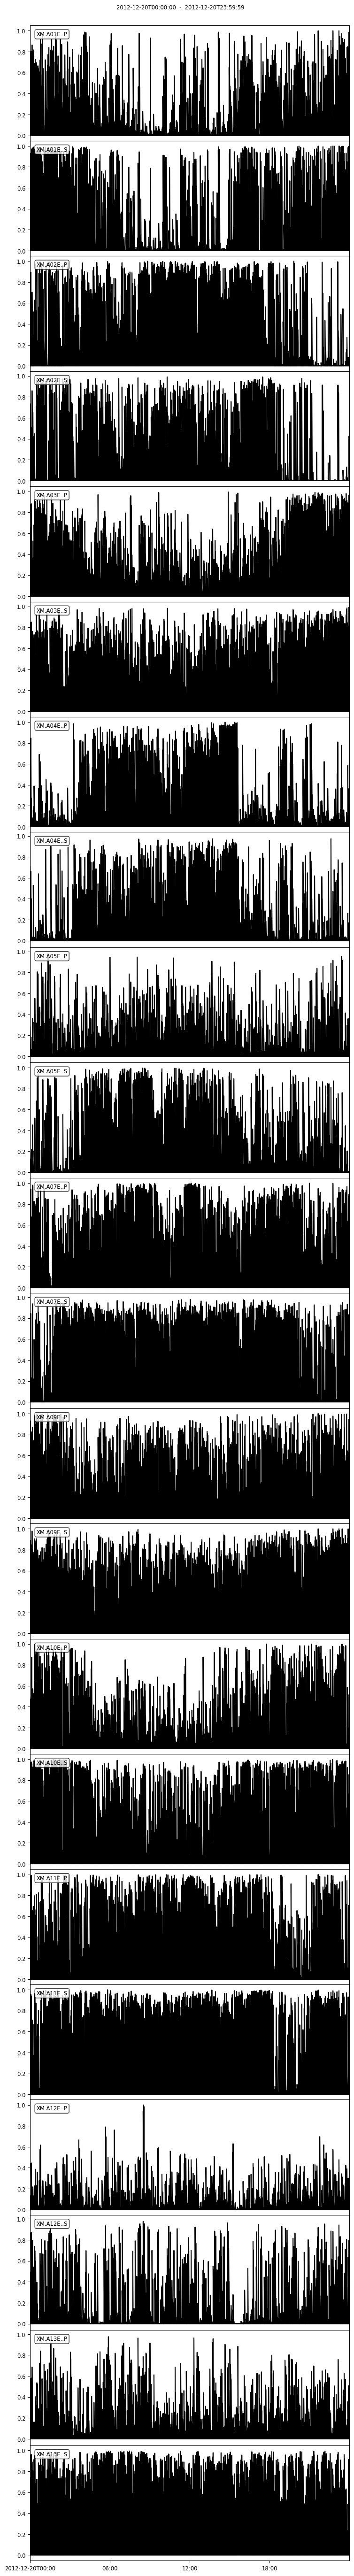

In [15]:
# Plot of machine learning prediction traces for each station
st_pred.plot()

In [16]:
# Machine learning picks (when above predictions exceed threshold of 0.4)
df

,time,sta,pha,prob
0,2012-12-20T00:00:01.620000Z,A11E,s,0.736568
1,2012-12-20T00:00:01.900000Z,A01E,s,0.521099
2,2012-12-20T00:00:07.460000Z,A07E,p,0.733213
3,2012-12-20T00:00:08.340000Z,A09E,s,0.603118
4,2012-12-20T00:00:09.710000Z,A11E,p,0.421696
...,...,...,...,...
45877,2012-12-20T23:59:42.950000Z,A13E,s,0.567021
45878,2012-12-20T23:59:47.770000Z,A13E,s,0.985648
45879,2012-12-20T23:59:49.030000Z,A03E,s,0.633351
45880,2012-12-20T23:59:50.530000Z,A09E,s,0.801582


In [17]:
# By station
for s in list(set(df['sta'])):
    no_p_picks = df.loc[(df['sta'] == s) & (df['pha'] == "p")].shape[0]
    no_s_picks = df.loc[(df['sta'] == s) & (df['pha'] == "s")].shape[0]
    print("Station " + s + ": " + str(no_p_picks) + " P-waves and " + str(no_s_picks) + " S-waves.")

Station A07E: 3288 P-waves and 4408 S-waves.
Station A13E: 386 P-waves and 4914 S-waves.
Station A12E: 93 P-waves and 337 S-waves.
Station A01E: 1049 P-waves and 1561 S-waves.
Station A11E: 3234 P-waves and 4508 S-waves.
Station A10E: 1196 P-waves and 2661 S-waves.
Station A03E: 1547 P-waves and 1814 S-waves.
Station A05E: 336 P-waves and 1926 S-waves.
Station A09E: 1767 P-waves and 2296 S-waves.
Station A04E: 2490 P-waves and 1172 S-waves.
Station A02E: 3302 P-waves and 1597 S-waves.


In [18]:
df_p = df.loc[df['pha'] == "p"] # Extract just P-wave picks
df_p.reset_index(drop=True, inplace=True) # Reset dataframe indexing

pick_groups = [] # Create empty list to store P-wave groupings

# First loop through each pick finding all picks within 4 seconds of that pick - this takes around 20 secs
for i in range(df_p.shape[0]):
    this_time = df_p['time'][i]
    this_bin = df_p.loc[(df_p['time'] >= this_time) & (df_p['time'] <= (this_time + 4))]
    
    # If 4+ stations then add to pick_groups list
    if this_bin.shape[0] >= 4:
        if len(list(set(this_bin['sta']))) >= 4:
            pick_groups.append(this_bin)

# Remove groups that are fully contained in another
# First 'backwards' (remove groups that are fully contained in the previous group)
for i in reversed(range(len(pick_groups))):
    if i == 0:
        continue
    else:
        if pick_groups[i].isin(pick_groups[(i-1)]).all().all():
            del(pick_groups[i])
# Then 'forwards' (remove groups that are fully contained in the next group)
for i in reversed(range(len(pick_groups)-1)):
    if pick_groups[i].isin(pick_groups[(i+1)]).all().all():
        del(pick_groups[i])

print("Total no. of P-wave groups = " + str(len(pick_groups)))

Total no. of P-wave groups = 294


In [19]:
pick_groups

[                            time   sta pha      prob
 216  2012-12-20T00:28:50.770000Z  A09E   p  0.442165
 217  2012-12-20T00:28:52.980000Z  A11E   p  0.463980
 218  2012-12-20T00:28:54.320000Z  A01E   p  0.694168
 219  2012-12-20T00:28:54.420000Z  A07E   p  0.537760,
                             time   sta pha      prob
 256  2012-12-20T00:32:44.530000Z  A01E   p  0.460412
 257  2012-12-20T00:32:45.610000Z  A09E   p  0.459543
 258  2012-12-20T00:32:45.640000Z  A03E   p  0.916286
 259  2012-12-20T00:32:46.030000Z  A09E   p  0.418021
 260  2012-12-20T00:32:46.720000Z  A10E   p  0.915110
 261  2012-12-20T00:32:47.000000Z  A03E   p  0.801030
 262  2012-12-20T00:32:47.870000Z  A10E   p  0.511925,
                             time   sta pha      prob
 257  2012-12-20T00:32:45.610000Z  A09E   p  0.459543
 258  2012-12-20T00:32:45.640000Z  A03E   p  0.916286
 259  2012-12-20T00:32:46.030000Z  A09E   p  0.418021
 260  2012-12-20T00:32:46.720000Z  A10E   p  0.915110
 261  2012-12-20T00:32:47.

In [20]:
# Check for any groups that have more than 1 pick - first increase threshold for all picks then use phase w/ highest prob
for i in reversed(range(len(pick_groups))):
    if pick_groups[i]['sta'].duplicated().any(): # If more than one pick for any station
        pick_groups[i] = pick_groups[i].loc[pick_groups[i]['prob'] >= 0.6] # First only keep picks above higher threshold (0.6)

        if len(list(set(pick_groups[i]['sta']))) < 4:
            del(pick_groups[i]) # Remove group if increased threshold reduces number of stations to less than 4
        else:
            # Otherwise check if any stations still have more than one pick and keep only highest probability pick
            if pick_groups[i]['sta'].duplicated().any():
                pick_groups[i] = pick_groups[i].sort_values('prob').drop_duplicates('sta', keep='last')

print("No. of P-wave groups after increasing threshold for groups with multiple picks per station and reducing no. of picks to one per station = " + str(len(pick_groups)))

# Then check for overlapping groups and choose group with highest mean probability
for i in reversed(range(len(pick_groups)-1)):
    if pick_groups[i].index.isin(pick_groups[i+1].index).any():
        if np.mean(pick_groups[i]['prob']) >= np.mean(pick_groups[i+1]['prob']):
            del(pick_groups[i+1])
        else:
            del(pick_groups[i])

print("No. of P-wave groups after removing overlapping groups = " + str(len(pick_groups)))

No. of P-wave groups after increasing threshold for groups with multiple picks per station and reducing no. of picks to one per station = 111
No. of P-wave groups after removing overlapping groups = 96


In [21]:
# Make directories to store NLL pickfile, velocity model, travel time grid and locations
!mkdir ./NLL
!mkdir ./NLL/picks
!mkdir ./NLL/model
!mkdir ./NLL/time
!mkdir ./NLL/loc

mkdir: ./NLL: File exists
mkdir: ./NLL/picks: File exists
mkdir: ./NLL/model: File exists
mkdir: ./NLL/time: File exists
mkdir: ./NLL/loc: File exists


In [22]:
# Loop through groups of picks, producing strings to go in NonLinLoc phase input file (e.g., http://alomax.free.fr/nlloc/soft7.00/formats.html#_phase_nlloc_)
# And then write strings to NLL phase input file

phase_file_str = [] # List to store strings for NLL phase input file

# Loop through groups and picks producing appropriate strings for phase input file
for i in range(len(pick_groups)):
    pick_groups[i].reset_index(drop=True, inplace=True) # Reset indices for each dataframe for looping through
    for j in range(pick_groups[i].shape[0]):
        if (i > 0) and (j == 0):
            phase_file_str.append(" ") # Add a blank line after each event
        this_line = pick_groups[i]['sta'][j].ljust(7) # Station
        this_line += '?'.ljust(5) # Instrument (leave as ?)
        this_line += "?".ljust(5) # Component (leave as ?)
        this_line += "? P".ljust(9) # Onset (leave as ? as don't know if impulsive or emergent) and phase descriptor (P)
        this_line += "? " # First motion (i.e. compression/dilation, leave as ? as don't know)
        this_line += str(pick_groups[i]['time'][j].year) # Year
        this_line += str(pick_groups[i]['time'][j].month).zfill(2) # Month (2 digits)
        this_line += str(pick_groups[i]['time'][j].day).zfill(2) # Day (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].hour).zfill(2) # Hour (2 digits)
        this_line += str(pick_groups[i]['time'][j].minute).zfill(2) # Minute (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].second).zfill(2) # Second (2 digits)
        this_line += "." + str(pick_groups[i]['time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
        this_line += " GAU " # Error type = Gaussian
        if pick_groups[i]['prob'][j] >= 0.85:
            this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
        elif pick_groups[i]['prob'][j] >= 0.7:
            this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
        elif pick_groups[i]['prob'][j] >= 0.55:
            this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
        else:
            this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
        this_line += "-1.00e+00 " # Coda duration (negative = don't use)
        this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
        this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

        phase_file_str.append(this_line) # Append line to list

# Write phase input file
with open('./NLL/picks/pickfile.hpf', 'w') as f:
    for item in phase_file_str:
        f.write("%s\n" % item)


In [23]:
#!wget http://alomax.free.fr/nlloc/soft7.00/tar/NLL7.00_src.tgz; tar -zxf NLL7.00_src.tgz; cd src; make distrib

In [24]:
!/Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/bin/Vel2Grid /Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/U-GPD/NLL/NLL_master.in
!/Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/bin/Grid2Time /Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/U-GPD/NLL/NLL_master.in


Recursive initialization: level 1
Rediscretized timefield dimensions: 31 31 18
Homogeneous region: x[15->16] y[15->16] z[2->3]

Starting F.D. computation...
Starting F.D. computation...
x_side 80->79: ff fb bb bf 
y_side 72->71: ff fb bb bf 
x_side 94->95: ff fb bb bf 
y_side 86->87: ff fb bb bf 
z_side 8->9: ff fb bb bf 
x_side 79->78: ff fb bb bf 
y_side 71->70: ff fb bb bf 
x_side 95->96: ff fb bb bf 
y_side 87->88: ff fb bb bf 
z_side 9->10: ff fb bb bf 
x_side 78->77: ff fb bb bf 
y_side 70->69: ff fb bb bf 
x_side 96->97: ff fb bb bf 
y_side 88->89: ff fb bb bf 
z_side 10->11: ff fb bb bf 
x_side 77->76: ff fb bb bf 
y_side 69->68: ff fb bb bf 
x_side 97->98: ff fb bb bf 
y_side 89->90: ff fb bb bf 
z_side 11->12: ff fb bb bf 
x_side 76->75: ff fb bb bf 
y_side 68->67: ff fb bb bf 
x_side 98->99: ff fb bb bf 
y_side 90->91: ff fb bb bf 
z_side 12->13: ff fb bb bf 
x_side 75->74: ff fb bb bf 
y_side 67->66: ff fb bb bf 
x_side 99->100: ff fb bb bf 
y_side 91->92: ff fb bb bf 
z_s

y_side 10->9: ff fb bb bf 
x_side 156->157: ff fb bb bf 
y_side 148->149: ff fb bb bf 
z_side 70->71: ff fb bb bf 
x_side 17->16: ff fb bb bf 
y_side 9->8: ff fb bb bf 
x_side 157->158: ff fb bb bf 
y_side 149->150: ff fb bb bf 
z_side 71->72: ff fb bb bf 
x_side 16->15: ff fb bb bf 
y_side 8->7: ff fb bb bf 
x_side 158->159: ff fb bb bf 
y_side 150->151: ff fb bb bf 
z_side 72->73: ff fb bb bf 
x_side 15->14: ff fb bb bf 
y_side 7->6: ff fb bb bf 
x_side 159->160: ff fb bb bf 
y_side 151->152: ff fb bb bf 
z_side 73->74: ff fb bb bf 
x_side 14->13: ff fb bb bf 
y_side 6->5: ff fb bb bf 
y_side 152->153: ff fb bb bf 
z_side 74->75: ff fb bb bf 
x_side 13->12: ff fb bb bf 
y_side 5->4: ff fb bb bf 
y_side 153->154: ff fb bb bf 
z_side 75->76: ff fb bb bf 
x_side 12->11: ff fb bb bf 
y_side 4->3: ff fb bb bf 
y_side 154->155: ff fb bb bf 
z_side 76->77: ff fb bb bf 
x_side 11->10: ff fb bb bf 
y_side 3->2: ff fb bb bf 
y_side 155->156: ff fb bb bf 
z_side 77->78: ff fb bb bf 
x_side 10->

y_side 42->41: ff fb bb bf bb 
x_side 143->144: ff fb bb bf 
y_side 148->149: ff fb bb bf bb 
z_side 55->56: ff fb bb bf 
x_side 36->35: ff fb bb bf 
y_side 41->40: ff fb bb bf bb 
x_side 144->145: ff fb bb bf 
y_side 149->150: ff fb bb bf bb 
z_side 56->57: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 40->39: ff fb bb bf bb 
x_side 145->146: ff fb bb bf 
y_side 150->151: ff fb bb bf bb 
z_side 57->58: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 39->38: ff fb bb bf bb 
x_side 146->147: ff fb bb bf 
y_side 151->152: ff fb bb bf bb 
z_side 58->59: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 38->37: ff fb bb bf bb 
x_side 147->148: ff fb bb bf 
y_side 152->153: ff fb bb bf bb 
z_side 59->60: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 37->36: ff fb bb bf bb 
x_side 148->149: ff fb bb bf 
y_side 153->154: ff fb bb bf bb 
z_side 60->61: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 36->35: ff fb bb bf bb 
x_side 149->150: ff fb bb bf 
y_side 154->155: ff fb bb bf bb 
z_side

z_side 52->53: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 32->31: ff fb bb bf 
x_side 134->135: ff fb bb bf 
y_side 136->137: ff fb bb bf bb 
z_side 53->54: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 31->30: ff fb bb bf 
x_side 135->136: ff fb bb bf 
y_side 137->138: ff fb bb bf bb 
z_side 54->55: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 30->29: ff fb bb bf 
x_side 136->137: ff fb bb bf 
y_side 138->139: ff fb bb bf bb 
z_side 55->56: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 29->28: ff fb bb bf 
x_side 137->138: ff fb bb bf 
y_side 139->140: ff fb bb bf bb 
z_side 56->57: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 28->27: ff fb bb bf 
x_side 138->139: ff fb bb bf bb 
y_side 140->141: ff fb bb bf bb 
z_side 57->58: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 27->26: ff fb bb bf 
x_side 139->140: ff fb bb bf 
y_side 141->142: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 26->25: ff fb bb bf 
x_side 140->141: ff fb bb bf 
y_si

y_side 125->126: ff fb bb bf 
z_side 54->55: ff fb bb bf 
x_side 13->12: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 119->120: ff fb bb bf bb 
y_side 126->127: ff fb bb bf 
z_side 55->56: ff fb bb bf 
x_side 12->11: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 120->121: ff fb bb bf bb 
y_side 127->128: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 11->10: ff fb bb bf 
y_side 18->17: ff fb bb bf 
x_side 121->122: ff fb bb bf bb 
y_side 128->129: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 10->9: ff fb bb bf 
y_side 17->16: ff fb bb bf 
x_side 122->123: ff fb bb bf bb 
y_side 129->130: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 9->8: ff fb bb bf 
y_side 16->15: ff fb bb bf 
x_side 123->124: ff fb bb bf bb 
y_side 130->131: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 8->7: ff fb bb bf 
y_side 15->14: ff fb bb bf 
x_side 124->125: ff fb bb bf bb 
y_side 131->132: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 7->6: ff fb bb bf 
y_side 14->13: ff fb bb bf 
x_side 125-

x_side 121->122: ff fb bb bf bb 
y_side 138->139: ff fb bb bf bb 
z_side 49->50: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 43->42: ff fb bb bf 
x_side 122->123: ff fb bb bf bb 
y_side 139->140: ff fb bb bf bb 
z_side 50->51: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 42->41: ff fb bb bf 
x_side 123->124: ff fb bb bf bb 
y_side 140->141: ff fb bb bf bb 
z_side 51->52: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 41->40: ff fb bb bf 
x_side 124->125: ff fb bb bf bb 
y_side 141->142: ff fb bb bf bb 
z_side 52->53: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 40->39: ff fb bb bf 
x_side 125->126: ff fb bb bf bb 
y_side 142->143: ff fb bb bf bb 
z_side 53->54: ff fb bb bf 
x_side 22->21: ff fb bb bf 
y_side 39->38: ff fb bb bf 
x_side 126->127: ff fb bb bf bb 
y_side 143->144: ff fb bb bf bb 
z_side 54->55: ff fb bb bf 
x_side 21->20: ff fb bb bf 
y_side 38->37: ff fb bb bf 
x_side 127->128: ff fb bb bf bb 
y_side 144->145: ff fb bb bf bb 
z_side 55->56: ff fb bb bf 
x_side

y_side 132->133: ff fb bb bf 
z_side 53->54: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 27->26: ff fb bb bf 
x_side 141->142: ff fb bb bf 
y_side 133->134: ff fb bb bf 
z_side 54->55: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 26->25: ff fb bb bf 
x_side 142->143: ff fb bb bf 
y_side 134->135: ff fb bb bf 
z_side 55->56: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 25->24: ff fb bb bf 
x_side 143->144: ff fb bb bf 
y_side 135->136: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 24->23: ff fb bb bf 
x_side 144->145: ff fb bb bf 
y_side 136->137: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 23->22: ff fb bb bf 
x_side 145->146: ff fb bb bf 
y_side 137->138: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 22->21: ff fb bb bf 
x_side 146->147: ff fb bb bf 
y_side 138->139: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 147->148: ff fb

x_side 129->130: ff fb bb bf 
y_side 108->109: ff fb bb bf 
z_side 52->53: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 7->6: ff fb bb bf 
x_side 130->131: ff fb bb bf 
y_side 109->110: ff fb bb bf 
z_side 53->54: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 6->5: ff fb bb bf 
x_side 131->132: ff fb bb bf 
y_side 110->111: ff fb bb bf 
z_side 54->55: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 5->4: ff fb bb bf 
x_side 132->133: ff fb bb bf 
y_side 111->112: ff fb bb bf 
z_side 55->56: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 4->3: ff fb bb bf 
x_side 133->134: ff fb bb bf 
y_side 112->113: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 3->2: ff fb bb bf 
x_side 134->135: ff fb bb bf 
y_side 113->114: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 2->1: ff fb bb bf 
x_side 135->136: ff fb bb bf 
y_side 114->115: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 22->21: ff fb bb bf 
y_side 1->0: ff fb bb bf 
x_side

x_side 147->148: ff fb bb bf 
y_side 115->116: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 38->37: ff fb bb bf 
y_side 6->5: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 116->117: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 37->36: ff fb bb bf 
y_side 5->4: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 117->118: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 36->35: ff fb bb bf 
y_side 4->3: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 118->119: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 3->2: ff fb bb bf 
x_side 151->152: ff fb bb bf 
y_side 119->120: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 2->1: ff fb bb bf 
x_side 152->153: ff fb bb bf 
y_side 120->121: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 1->0: ff fb bb bf 
x_side 153->154: ff fb bb bf 
y_side 121->122: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 32->31: ff fb bb bf 
x_side 154->155: ff fb bb bf 
y_

z_side 56->57: ff fb bb bf 
x_side 36->35: ff fb bb bf 
y_side 23->22: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 135->136: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 22->21: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 136->137: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 137->138: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 151->152: ff fb bb bf 
y_side 138->139: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 152->153: ff fb bb bf 
y_side 139->140: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 18->17: ff fb bb bf 
x_side 153->154: ff fb bb bf 
y_side 140->141: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 17->16: ff fb bb bf 
x_side 154->155: ff fb bb bf 
y_side 141->142: ff fb

z_side 57->58: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 25->24: ff fb bb bf 
x_side 146->147: ff fb bb bf 
y_side 139->140: ff fb bb bf bb 
z_side 58->59: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 24->23: ff fb bb bf 
x_side 147->148: ff fb bb bf 
y_side 140->141: ff fb bb bf bb 
z_side 59->60: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 23->22: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 141->142: ff fb bb bf bb 
z_side 60->61: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 22->21: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 142->143: ff fb bb bf bb 
z_side 61->62: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 143->144: ff fb bb bf bb 
z_side 62->63: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 151->152: ff fb bb bf 
y_side 144->145: ff fb bb bf bb 
z_side 63->64: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 152->153: ff fb bb bf 
y_si

y_side 138->139: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 23->22: ff fb bb bf 
x_side 143->144: ff fb bb bf 
y_side 139->140: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 22->21: ff fb bb bf 
x_side 144->145: ff fb bb bf 
y_side 140->141: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 145->146: ff fb bb bf 
y_side 141->142: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 146->147: ff fb bb bf 
y_side 142->143: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 147->148: ff fb bb bf 
y_side 143->144: ff fb bb bf 
z_side 63->64: ff fb bb bf 
x_side 22->21: ff fb bb bf 
y_side 18->17: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 144->145: ff fb bb bf 
z_side 64->65: ff fb bb bf 
x_side 21->20: ff fb bb bf 
y_side 17->16: ff fb bb bf 
x_side 149->150: ff fb

x_side 147->148: ff fb bb bf 
y_side 127->128: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 12->11: ff fb bb bf bb 
x_side 148->149: ff fb bb bf 
y_side 128->129: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 11->10: ff fb bb bf bb 
x_side 149->150: ff fb bb bf 
y_side 129->130: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 10->9: ff fb bb bf bb 
x_side 150->151: ff fb bb bf 
y_side 130->131: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 9->8: ff fb bb bf bb 
x_side 151->152: ff fb bb bf 
y_side 131->132: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 8->7: ff fb bb bf bb 
x_side 152->153: ff fb bb bf 
y_side 132->133: ff fb bb bf 
z_side 63->64: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 7->6: ff fb bb bf bb 
x_side 153->154: ff fb bb bf 
y_side 133->134: ff fb bb bf 
z_side 64->65: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 6-

y_side 143->144: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 47->46: ff fb bb bf 
y_side 32->31: ff fb bb bf 
x_side 159->160: ff fb bb bf bb 
y_side 144->145: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 46->45: ff fb bb bf 
y_side 31->30: ff fb bb bf 
y_side 145->146: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 45->44: ff fb bb bf 
y_side 30->29: ff fb bb bf 
y_side 146->147: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 44->43: ff fb bb bf 
y_side 29->28: ff fb bb bf 
y_side 147->148: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 43->42: ff fb bb bf 
y_side 28->27: ff fb bb bf 
y_side 148->149: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 42->41: ff fb bb bf 
y_side 27->26: ff fb bb bf 
y_side 149->150: ff fb bb bf 
z_side 63->64: ff fb bb bf 
x_side 41->40: ff fb bb bf 
y_side 26->25: ff fb bb bf 
y_side 150->151: ff fb bb bf 
z_side 64->65: ff fb bb bf 
x_side 40->39: ff fb bb bf 
y_side 25->24: ff fb bb bf 
y_side 151->152: ff fb bb bf 
z_side 65->66: ff fb bb b

z_side 56->57: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 41->40: ff fb bb bf bb 
x_side 139->140: ff fb bb bf 
y_side 151->152: ff fb bb bf bb 
z_side 57->58: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 40->39: ff fb bb bf bb 
x_side 140->141: ff fb bb bf 
y_side 152->153: ff fb bb bf bb 
z_side 58->59: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 39->38: ff fb bb bf bb 
x_side 141->142: ff fb bb bf 
y_side 153->154: ff fb bb bf bb 
z_side 59->60: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 38->37: ff fb bb bf bb 
x_side 142->143: ff fb bb bf 
y_side 154->155: ff fb bb bf bb 
z_side 60->61: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 37->36: ff fb bb bf bb 
x_side 143->144: ff fb bb bf 
y_side 155->156: ff fb bb bf bb 
z_side 61->62: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 36->35: ff fb bb bf 
x_side 144->145: ff fb bb bf 
y_side 156->157: ff fb bb bf bb 
z_side 62->63: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 35->34: ff fb bb bf bb 
x_side 145->146:

In [25]:
!/Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/bin/NLLoc /Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/U-GPD/NLL/NLL_master.in

Finished event location, output files: ./NLL/loc/ALL.20121220.002850.* <./NLL/loc/ALL.20121220.002850.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.003255.* <./NLL/loc/ALL.20121220.003255.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.011912.* <./NLL/loc/ALL.20121220.011912.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.040318.* <./NLL/loc/ALL.20121220.040318.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.041104.* <./NLL/loc/ALL.20121220.041104.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.053019.* <./NLL/loc/ALL.20121220.053019.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.053120.* <./NLL/loc/ALL.20121220.053120.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.053652.* <./NLL/loc/ALL.20121220.053652.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.06

Finished event location, output files: ./NLL/loc/ALL.20121220.153002.* <./NLL/loc/ALL.20121220.153002.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.153015.* <./NLL/loc/ALL.20121220.153015.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.153233.* <./NLL/loc/ALL.20121220.153233.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.153639.* <./NLL/loc/ALL.20121220.153639.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.153704.* <./NLL/loc/ALL.20121220.153704.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.155609.* <./NLL/loc/ALL.20121220.155609.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.161309.* <./NLL/loc/ALL.20121220.161309.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.162335.* <./NLL/loc/ALL.20121220.162335.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc/ALL.20121220.16

In [26]:
# Read in origin times from NLL location summary file:
with open("./NLL/loc/ALL.sum.grid0.loc.hyp","r") as fi:
    origins = []
    for ln in fi:
        if ln.startswith("GEOGRAPHIC"):
            origins.append(ln[15:42]) # Take origin time info from GEOGRAPHIC line in summary hyp file

# Loop through and convert origin times to UTCDateTime
for i in range(len(origins)):
    origins[i] = UTCDateTime(origins[i][:4] + origins[i][5:7] + origins[i][8:10] + "T" + origins[i][12:14] + origins[i][15:17] + ("%.4f" % float(origins[i][18:27])).zfill(7))

# Get dataframe of model S-wave picks
df_s = df.loc[df['pha'] == "s"] # Extract just S-wave picks
df_s.reset_index(drop=True, inplace=True) # Reset dataframe indexing

# Then loop through P-wave pick groups finding any S-waves to add:
for i in range(len(pick_groups)):
    # Add columns for new S-wave times and probabilities:
    pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
    pick_groups[i]['s_prob'] = 0. # Put zero probability initially
    # Loop through picks in each group
    for j in range(pick_groups[i].shape[0]):
        p_origin_diff = pick_groups[i]['time'][j] - origins[i] # P arrival time minus origin time
        s_window = df_s.loc[(df_s['time'] >= origins[i] + (p_origin_diff * 1.76 * 0.67)) & (df_s['time'] <= origins[i] + (p_origin_diff * 1.76 * 1.5))] # Any picks within predicted S arrival window?
        s_window = s_window.loc[s_window['sta'] == pick_groups[i]['sta'][j]] # Any S picks within window and from this station?
        # If so...
        if s_window.shape[0] > 0:
            if s_window.shape[0] > 1:
                # If more than one pick for this station, use pick with highest probability
                s_window = s_window.sort_values('prob').drop_duplicates('sta', keep='last')
            s_window.reset_index(inplace=True, drop=True) # Reset index
            # Add pick to pick_groups dataframe
            pick_groups[i]['s_time'][j] = s_window['time'][0]
            pick_groups[i]['s_prob'][j] = s_window['prob'][0]

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWa

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWa

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWa

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWa

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'][j] = s_window['time'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'][j] = s_window['prob'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'][j] = s_window['time'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'][j] = s_window['prob'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'][j] = s_window['time'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'][j] = s_window['prob'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'][j] = s_window['time'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'][j] = s_window['prob'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'][j] = s_window['time'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'][j] = s_window['prob'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWa

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWa

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'][j] = s_window['time'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'][j] = s_window['prob'][0]
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_time'] = pick_groups[i]['time'] # Just put S-wave time = P-wave time initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pick_groups[i]['s_prob'] = 0. # Put zero probability initially
/var/folders/y7/fgbbhrsd30bglpmrj_t4bkm40000gn/T/ipykernel_2731/249715853.py:33: SettingWithCopyWa

In [27]:
# A quick look at our new groupings
pick_groups

[                          time   sta pha      prob  \
 0  2012-12-20T00:28:50.770000Z  A09E   p  0.442165   
 1  2012-12-20T00:28:52.980000Z  A11E   p  0.463980   
 2  2012-12-20T00:28:54.320000Z  A01E   p  0.694168   
 3  2012-12-20T00:28:54.420000Z  A07E   p  0.537760   
 
                         s_time   s_prob  
 0  2012-12-20T00:28:50.770000Z  0.00000  
 1  2012-12-20T00:28:52.980000Z  0.00000  
 2  2012-12-20T00:28:55.230000Z  0.82411  
 3  2012-12-20T00:28:54.420000Z  0.00000  ,
                           time   sta pha      prob  \
 0  2012-12-20T00:32:55.480000Z  A10E   p  0.592579   
 1  2012-12-20T00:32:55.630000Z  A05E   p  0.805993   
 2  2012-12-20T00:32:58.420000Z  A09E   p  0.912556   
 3  2012-12-20T00:32:58.860000Z  A01E   p  0.628293   
 
                         s_time    s_prob  
 0  2012-12-20T00:32:55.480000Z  0.000000  
 1  2012-12-20T00:32:55.630000Z  0.000000  
 2  2012-12-20T00:32:58.420000Z  0.000000  
 3  2012-12-20T00:32:59.360000Z  0.837799  ,
         

In [28]:
# Rewrite NLL phase input file:

phase_file_str = [] # Empty list to store strings for NLL phase input file

# Loop through groups and picks producing appropriate strings for phase input file
for i in range(len(pick_groups)):
    pick_groups[i].reset_index(drop=True, inplace=True) # Reset indices for each dataframe for looping through
    for j in range(pick_groups[i].shape[0]):
        if (i > 0) and (j == 0):
            phase_file_str.append(" ") # Add a blank line after each event
        this_line = pick_groups[i]['sta'][j].ljust(7) # Station
        this_line += '?'.ljust(5) # Instrument (leave as ?)
        this_line += "?".ljust(5) # Component (leave as ?)
        this_line += "? P".ljust(9) # Onset (leave as ? as don't know if impulsive or emergent) and phase descriptor (P)
        this_line += "? " # First motion (i.e. compression/dilation, leave as ? as don't know)
        this_line += str(pick_groups[i]['time'][j].year) # Year
        this_line += str(pick_groups[i]['time'][j].month).zfill(2) # Month (2 digits)
        this_line += str(pick_groups[i]['time'][j].day).zfill(2) # Day (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].hour).zfill(2) # Hour (2 digits)
        this_line += str(pick_groups[i]['time'][j].minute).zfill(2) # Minute (2 digits)
        this_line += " " + str(pick_groups[i]['time'][j].second).zfill(2) # Second (2 digits)
        this_line += "." + str(pick_groups[i]['time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
        this_line += " GAU " # Error type = Gaussian
        if pick_groups[i]['prob'][j] >= 0.85:
            this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
        elif pick_groups[i]['prob'][j] >= 0.7:
            this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
        elif pick_groups[i]['prob'][j] >= 0.55:
            this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
        else:
            this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
        this_line += "-1.00e+00 " # Coda duration (negative = don't use)
        this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
        this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

        phase_file_str.append(this_line) # Append line to list

        # Check if there is an associated S-wave pick for this station and append to the phase file:
        if pick_groups[i]['s_prob'][j] >= 0.4:
            this_line = pick_groups[i]['sta'][j].ljust(7) # Station
            this_line += '?'.ljust(5) # Instrument (leave as ?)
            this_line += "?".ljust(5) # Component (leave as ?)
            this_line += "? S".ljust(9) # Onset (leave as ? as now S-wave) and phase descriptor (S)
            this_line += "? " # First motion (i.e. compression/dilation, leave as ? as now S-wave)
            this_line += str(pick_groups[i]['s_time'][j].year) # Year
            this_line += str(pick_groups[i]['s_time'][j].month).zfill(2) # Month (2 digits)
            this_line += str(pick_groups[i]['s_time'][j].day).zfill(2) # Day (2 digits)
            this_line += " " + str(pick_groups[i]['s_time'][j].hour).zfill(2) # Hour (2 digits)
            this_line += str(pick_groups[i]['s_time'][j].minute).zfill(2) # Minute (2 digits)
            this_line += " " + str(pick_groups[i]['s_time'][j].second).zfill(2) # Second (2 digits)
            this_line += "." + str(pick_groups[i]['s_time'][j].microsecond).zfill(4)[:4] # Microseconds (4 digits)
            this_line += " GAU " # Error type = Gaussian
            # Keep same error magnitudes as P-wave arrivals
            if pick_groups[i]['prob'][j] >= 0.85:
                this_line += "5.00e-02 " # 0.05 sec err for prob >= 0.85
            elif pick_groups[i]['prob'][j] >= 0.7:
                this_line += "1.00e-01 " # 0.10 sec err for prob >= 0.7
            elif pick_groups[i]['prob'][j] >= 0.55:
                this_line += "2.00e-01 " # 0.20 sec err for prob >= 0.55
            else:
                this_line += "3.33e-01 " # 0.333 sec err for prob >= 0.4
            this_line += "-1.00e+00 " # Coda duration (negative = don't use)
            this_line += "-1.00e+00 " # Max peak-to-peak amplitude (negative = don't use)
            this_line += "-1.00e+00" # Period of amplitude reading (negative = don't use)

            phase_file_str.append(this_line) # Append line to list

# Write new phase file
with open('./NLL/picks/pickfile_s.hpf', 'w') as f:
    for item in phase_file_str:
        f.write("%s\n" % item)

In [29]:
# Make new directory for locating events with S-waves included:
!mkdir ./NLL/loc_s

mkdir: ./NLL/loc_s: File exists


In [30]:
#### UNCOMMENT THESE LINES IF USING DEFINED S-WAVE VELOCITY (i.e., not using constant Vp/Vs ratio) ####

# Create velocity and travel-time grids for S-wave velocity model
!/Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/bin/Vel2Grid /Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/U-GPD/NLL/NLL_master_s.in
!/Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/bin/Grid2Time /Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/U-GPD/NLL/NLL_master_s.in

# Run NonLinLoc again (using pre-made Control File for including S-waves)
!/Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/bin/NLLoc /Users/tesfahiwetyemane/Documents/DPhil/Aluto/NLL/U-GPD/NLL/NLL_master_s.in


Recursive initialization: level 1
Rediscretized timefield dimensions: 31 31 18
Homogeneous region: x[15->16] y[15->16] z[2->3]

Starting F.D. computation...
Starting F.D. computation...
x_side 80->79: ff fb bb bf 
y_side 72->71: ff fb bb bf 
x_side 94->95: ff fb bb bf 
y_side 86->87: ff fb bb bf 
z_side 8->9: ff fb bb bf 
x_side 79->78: ff fb bb bf 
y_side 71->70: ff fb bb bf 
x_side 95->96: ff fb bb bf 
y_side 87->88: ff fb bb bf 
z_side 9->10: ff fb bb bf 
x_side 78->77: ff fb bb bf 
y_side 70->69: ff fb bb bf 
x_side 96->97: ff fb bb bf 
y_side 88->89: ff fb bb bf 
z_side 10->11: ff fb bb bf 
x_side 77->76: ff fb bb bf 
y_side 69->68: ff fb bb bf 
x_side 97->98: ff fb bb bf 
y_side 89->90: ff fb bb bf 
z_side 11->12: ff fb bb bf 
x_side 76->75: ff fb bb bf 
y_side 68->67: ff fb bb bf 
x_side 98->99: ff fb bb bf 
y_side 90->91: ff fb bb bf 
z_side 12->13: ff fb bb bf 
x_side 75->74: ff fb bb bf 
y_side 67->66: ff fb bb bf 
x_side 99->100: ff fb bb bf 
y_side 91->92: ff fb bb bf 
z_s

y_side 145->146: ff fb bb bf 
z_side 67->68: ff fb bb bf 
x_side 20->19: ff fb bb bf 
y_side 12->11: ff fb bb bf 
x_side 154->155: ff fb bb bf 
y_side 146->147: ff fb bb bf 
z_side 68->69: ff fb bb bf 
x_side 19->18: ff fb bb bf 
y_side 11->10: ff fb bb bf 
x_side 155->156: ff fb bb bf 
y_side 147->148: ff fb bb bf 
z_side 69->70: ff fb bb bf 
x_side 18->17: ff fb bb bf 
y_side 10->9: ff fb bb bf 
x_side 156->157: ff fb bb bf 
y_side 148->149: ff fb bb bf 
z_side 70->71: ff fb bb bf 
x_side 17->16: ff fb bb bf 
y_side 9->8: ff fb bb bf 
x_side 157->158: ff fb bb bf 
y_side 149->150: ff fb bb bf 
z_side 71->72: ff fb bb bf 
x_side 16->15: ff fb bb bf 
y_side 8->7: ff fb bb bf 
x_side 158->159: ff fb bb bf 
y_side 150->151: ff fb bb bf 
z_side 72->73: ff fb bb bf 
x_side 15->14: ff fb bb bf 
y_side 7->6: ff fb bb bf 
x_side 159->160: ff fb bb bf 
y_side 151->152: ff fb bb bf 
z_side 73->74: ff fb bb bf 
x_side 14->13: ff fb bb bf 
y_side 6->5: ff fb bb bf 
y_side 152->153: ff fb bb bf 
z

x_side 152->153: ff fb bb bf 
y_side 157->158: ff fb bb bf 
z_side 64->65: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 32->31: ff fb bb bf 
x_side 153->154: ff fb bb bf 
y_side 158->159: ff fb bb bf 
z_side 65->66: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 31->30: ff fb bb bf 
x_side 154->155: ff fb bb bf 
y_side 159->160: ff fb bb bf 
z_side 66->67: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 30->29: ff fb bb bf 
x_side 155->156: ff fb bb bf 
z_side 67->68: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 29->28: ff fb bb bf 
x_side 156->157: ff fb bb bf 
z_side 68->69: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 28->27: ff fb bb bf 
x_side 157->158: ff fb bb bf 
z_side 69->70: ff fb bb bf 
x_side 22->21: ff fb bb bf 
y_side 27->26: ff fb bb bf 
x_side 158->159: ff fb bb bf 
z_side 70->71: ff fb bb bf 
x_side 21->20: ff fb bb bf 
y_side 26->25: ff fb bb bf 
x_side 159->160: ff fb bb bf 
z_side 71->72: ff fb bb bf 
x_side 20->19: ff fb bb bf 
y_side 25->24: ff fb bb bf

y_side 146->147: ff fb bb bf 
z_side 63->64: ff fb bb bf 
x_side 19->18: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 145->146: ff fb bb bf 
y_side 147->148: ff fb bb bf 
z_side 64->65: ff fb bb bf 
x_side 18->17: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 146->147: ff fb bb bf 
y_side 148->149: ff fb bb bf 
z_side 65->66: ff fb bb bf 
x_side 17->16: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 147->148: ff fb bb bf 
y_side 149->150: ff fb bb bf 
z_side 66->67: ff fb bb bf 
x_side 16->15: ff fb bb bf 
y_side 18->17: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 150->151: ff fb bb bf 
z_side 67->68: ff fb bb bf 
x_side 15->14: ff fb bb bf 
y_side 17->16: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 151->152: ff fb bb bf 
z_side 68->69: ff fb bb bf 
x_side 14->13: ff fb bb bf 
y_side 16->15: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 152->153: ff fb bb bf 
z_side 69->70: ff fb bb bf 
x_side 13->12: ff fb bb bf 
y_side 15->14: ff fb bb bf 
x_side 151->152: ff fb

z_side 54->55: ff fb bb bf 
x_side 13->12: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 119->120: ff fb bb bf 
y_side 126->127: ff fb bb bf 
z_side 55->56: ff fb bb bf 
x_side 12->11: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 120->121: ff fb bb bf 
y_side 127->128: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 11->10: ff fb bb bf 
y_side 18->17: ff fb bb bf 
x_side 121->122: ff fb bb bf 
y_side 128->129: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 10->9: ff fb bb bf 
y_side 17->16: ff fb bb bf 
x_side 122->123: ff fb bb bf 
y_side 129->130: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 9->8: ff fb bb bf 
y_side 16->15: ff fb bb bf 
x_side 123->124: ff fb bb bf 
y_side 130->131: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 8->7: ff fb bb bf 
y_side 15->14: ff fb bb bf 
x_side 124->125: ff fb bb bf 
y_side 131->132: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 7->6: ff fb bb bf 
y_side 14->13: ff fb bb bf 
x_side 125->126: ff fb bb bf 
y_side 132->133: ff fb bb bf 

y_side 42->41: ff fb bb bf 
x_side 123->124: ff fb bb bf bb 
y_side 140->141: ff fb bb bf bb 
z_side 51->52: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 41->40: ff fb bb bf 
x_side 124->125: ff fb bb bf bb 
y_side 141->142: ff fb bb bf bb 
z_side 52->53: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 40->39: ff fb bb bf 
x_side 125->126: ff fb bb bf bb 
y_side 142->143: ff fb bb bf bb 
z_side 53->54: ff fb bb bf 
x_side 22->21: ff fb bb bf 
y_side 39->38: ff fb bb bf 
x_side 126->127: ff fb bb bf bb 
y_side 143->144: ff fb bb bf bb 
z_side 54->55: ff fb bb bf 
x_side 21->20: ff fb bb bf 
y_side 38->37: ff fb bb bf 
x_side 127->128: ff fb bb bf bb 
y_side 144->145: ff fb bb bf bb 
z_side 55->56: ff fb bb bf 
x_side 20->19: ff fb bb bf 
y_side 37->36: ff fb bb bf 
x_side 128->129: ff fb bb bf bb 
y_side 145->146: ff fb bb bf bb 
z_side 56->57: ff fb bb bf 
x_side 19->18: ff fb bb bf 
y_side 36->35: ff fb bb bf 
x_side 129->130: ff fb bb bf bb 
y_side 146->147: ff fb bb bf bb 
z_side

z_side 47->48: ff fb bb bf 
x_side 41->40: ff fb bb bf 
y_side 33->32: ff fb bb bf 
x_side 135->136: ff fb bb bf 
y_side 127->128: ff fb bb bf 
z_side 48->49: ff fb bb bf 
x_side 40->39: ff fb bb bf 
y_side 32->31: ff fb bb bf 
x_side 136->137: ff fb bb bf 
y_side 128->129: ff fb bb bf 
z_side 49->50: ff fb bb bf 
x_side 39->38: ff fb bb bf 
y_side 31->30: ff fb bb bf 
x_side 137->138: ff fb bb bf 
y_side 129->130: ff fb bb bf 
z_side 50->51: ff fb bb bf 
x_side 38->37: ff fb bb bf 
y_side 30->29: ff fb bb bf 
x_side 138->139: ff fb bb bf 
y_side 130->131: ff fb bb bf 
z_side 51->52: ff fb bb bf 
x_side 37->36: ff fb bb bf 
y_side 29->28: ff fb bb bf 
x_side 139->140: ff fb bb bf 
y_side 131->132: ff fb bb bf 
z_side 52->53: ff fb bb bf 
x_side 36->35: ff fb bb bf 
y_side 28->27: ff fb bb bf 
x_side 140->141: ff fb bb bf 
y_side 132->133: ff fb bb bf 
z_side 53->54: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 27->26: ff fb bb bf 
x_side 141->142: ff fb bb bf 
y_side 133->134: ff fb

x_side 128->129: ff fb bb bf 
y_side 107->108: ff fb bb bf 
z_side 51->52: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 8->7: ff fb bb bf 
x_side 129->130: ff fb bb bf 
y_side 108->109: ff fb bb bf 
z_side 52->53: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 7->6: ff fb bb bf 
x_side 130->131: ff fb bb bf 
y_side 109->110: ff fb bb bf 
z_side 53->54: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 6->5: ff fb bb bf 
x_side 131->132: ff fb bb bf 
y_side 110->111: ff fb bb bf 
z_side 54->55: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 5->4: ff fb bb bf 
x_side 132->133: ff fb bb bf 
y_side 111->112: ff fb bb bf 
z_side 55->56: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 4->3: ff fb bb bf 
x_side 133->134: ff fb bb bf 
y_side 112->113: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 3->2: ff fb bb bf 
x_side 134->135: ff fb bb bf 
y_side 113->114: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 2->1: ff fb bb bf 
x_side

x_side 39->38: ff fb bb bf 
y_side 7->6: ff fb bb bf 
x_side 147->148: ff fb bb bf 
y_side 115->116: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 38->37: ff fb bb bf 
y_side 6->5: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 116->117: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 37->36: ff fb bb bf 
y_side 5->4: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 117->118: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 36->35: ff fb bb bf 
y_side 4->3: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 118->119: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 3->2: ff fb bb bf 
x_side 151->152: ff fb bb bf 
y_side 119->120: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 2->1: ff fb bb bf 
x_side 152->153: ff fb bb bf 
y_side 120->121: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 1->0: ff fb bb bf 
x_side 153->154: ff fb bb bf 
y_side 121->122: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side

z_side 56->57: ff fb bb bf 
x_side 36->35: ff fb bb bf 
y_side 23->22: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 135->136: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 22->21: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 136->137: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 137->138: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 151->152: ff fb bb bf 
y_side 138->139: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 152->153: ff fb bb bf 
y_side 139->140: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 18->17: ff fb bb bf 
x_side 153->154: ff fb bb bf 
y_side 140->141: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 17->16: ff fb bb bf 
x_side 154->155: ff fb bb bf 
y_side 141->142: ff fb

y_side 138->139: ff fb bb bf bb 
z_side 57->58: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 25->24: ff fb bb bf 
x_side 146->147: ff fb bb bf 
y_side 139->140: ff fb bb bf bb 
z_side 58->59: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 24->23: ff fb bb bf 
x_side 147->148: ff fb bb bf 
y_side 140->141: ff fb bb bf bb 
z_side 59->60: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 23->22: ff fb bb bf 
x_side 148->149: ff fb bb bf 
y_side 141->142: ff fb bb bf bb 
z_side 60->61: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 22->21: ff fb bb bf 
x_side 149->150: ff fb bb bf 
y_side 142->143: ff fb bb bf bb 
z_side 61->62: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 150->151: ff fb bb bf 
y_side 143->144: ff fb bb bf bb 
z_side 62->63: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 151->152: ff fb bb bf 
y_side 144->145: ff fb bb bf bb 
z_side 63->64: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x

z_side 56->57: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 25->24: ff fb bb bf 
x_side 141->142: ff fb bb bf 
y_side 137->138: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 28->27: ff fb bb bf 
y_side 24->23: ff fb bb bf 
x_side 142->143: ff fb bb bf 
y_side 138->139: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 27->26: ff fb bb bf 
y_side 23->22: ff fb bb bf 
x_side 143->144: ff fb bb bf 
y_side 139->140: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 26->25: ff fb bb bf 
y_side 22->21: ff fb bb bf 
x_side 144->145: ff fb bb bf 
y_side 140->141: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 25->24: ff fb bb bf 
y_side 21->20: ff fb bb bf 
x_side 145->146: ff fb bb bf 
y_side 141->142: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 24->23: ff fb bb bf 
y_side 20->19: ff fb bb bf 
x_side 146->147: ff fb bb bf 
y_side 142->143: ff fb bb bf 
z_side 62->63: ff fb bb bf 
x_side 23->22: ff fb bb bf 
y_side 19->18: ff fb bb bf 
x_side 147->148: ff fb bb bf 
y_side 143->144: ff fb

z_side 55->56: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 15->14: ff fb bb bf bb 
x_side 145->146: ff fb bb bf 
y_side 125->126: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 14->13: ff fb bb bf bb 
x_side 146->147: ff fb bb bf 
y_side 126->127: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 13->12: ff fb bb bf bb 
x_side 147->148: ff fb bb bf 
y_side 127->128: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 12->11: ff fb bb bf bb 
x_side 148->149: ff fb bb bf 
y_side 128->129: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 11->10: ff fb bb bf bb 
x_side 149->150: ff fb bb bf 
y_side 129->130: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 10->9: ff fb bb bf bb 
x_side 150->151: ff fb bb bf 
y_side 130->131: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 29->28: ff fb bb bf 
y_side 9->8: ff fb bb bf bb 
x_side 151->152: ff fb bb bf 
y_si

y_side 140->141: ff fb bb bf 
z_side 54->55: ff fb bb bf 
x_side 50->49: ff fb bb bf 
y_side 35->34: ff fb bb bf 
x_side 156->157: ff fb bb bf 
y_side 141->142: ff fb bb bf 
z_side 55->56: ff fb bb bf 
x_side 49->48: ff fb bb bf 
y_side 34->33: ff fb bb bf 
x_side 157->158: ff fb bb bf 
y_side 142->143: ff fb bb bf 
z_side 56->57: ff fb bb bf 
x_side 48->47: ff fb bb bf 
y_side 33->32: ff fb bb bf 
x_side 158->159: ff fb bb bf 
y_side 143->144: ff fb bb bf 
z_side 57->58: ff fb bb bf 
x_side 47->46: ff fb bb bf 
y_side 32->31: ff fb bb bf 
x_side 159->160: ff fb bb bf 
y_side 144->145: ff fb bb bf 
z_side 58->59: ff fb bb bf 
x_side 46->45: ff fb bb bf 
y_side 31->30: ff fb bb bf 
y_side 145->146: ff fb bb bf 
z_side 59->60: ff fb bb bf 
x_side 45->44: ff fb bb bf 
y_side 30->29: ff fb bb bf 
y_side 146->147: ff fb bb bf 
z_side 60->61: ff fb bb bf 
x_side 44->43: ff fb bb bf 
y_side 29->28: ff fb bb bf 
y_side 147->148: ff fb bb bf 
z_side 61->62: ff fb bb bf 
x_side 43->42: ff fb bb 

x_side 132->133: ff fb bb bf 
y_side 144->145: ff fb bb bf bb 
z_side 50->51: ff fb bb bf 
x_side 35->34: ff fb bb bf 
y_side 47->46: ff fb bb bf 
x_side 133->134: ff fb bb bf 
y_side 145->146: ff fb bb bf bb 
z_side 51->52: ff fb bb bf 
x_side 34->33: ff fb bb bf 
y_side 46->45: ff fb bb bf 
x_side 134->135: ff fb bb bf 
y_side 146->147: ff fb bb bf bb 
z_side 52->53: ff fb bb bf 
x_side 33->32: ff fb bb bf 
y_side 45->44: ff fb bb bf 
x_side 135->136: ff fb bb bf 
y_side 147->148: ff fb bb bf bb 
z_side 53->54: ff fb bb bf 
x_side 32->31: ff fb bb bf 
y_side 44->43: ff fb bb bf 
x_side 136->137: ff fb bb bf 
y_side 148->149: ff fb bb bf bb 
z_side 54->55: ff fb bb bf 
x_side 31->30: ff fb bb bf 
y_side 43->42: ff fb bb bf 
x_side 137->138: ff fb bb bf 
y_side 149->150: ff fb bb bf bb 
z_side 55->56: ff fb bb bf 
x_side 30->29: ff fb bb bf 
y_side 42->41: ff fb bb bf 
x_side 138->139: ff fb bb bf 
y_side 150->151: ff fb bb bf bb 
z_side 56->57: ff fb bb bf 
x_side 29->28: ff fb bb bf 

Finished event location, output files: ./NLL/loc_s/ALL.20121220.115605.* <./NLL/loc_s/ALL.20121220.115605.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20121220.120016.* <./NLL/loc_s/ALL.20121220.120016.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20121220.120136.* <./NLL/loc_s/ALL.20121220.120136.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20121220.120424.* <./NLL/loc_s/ALL.20121220.120424.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20121220.120504.* <./NLL/loc_s/ALL.20121220.120504.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20121220.120546.* <./NLL/loc_s/ALL.20121220.120546.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20121220.120728.* <./NLL/loc_s/ALL.20121220.120728.grid0.loc.hyp>
Finished event location, output files: ./NLL/loc_s/ALL.20121220.120759.* <./NLL/loc_s/ALL.20121220.120759.grid0.loc.hyp>
Finished event location, output 

In [31]:
#### LEAVE THESE LINES UNCOMMENTED IF USING CONSTANT Vp/Vs ####
# Run NonLinLoc again (using pre-made Control File for including S-waves)
#!./src/NLLoc ./U-GPD/NLL/NLL_master_s_constantVpVs.in

In [32]:
#origins = []
#lats = []
#lons = []
#depths = []

#with open("./NLL/loc_s/ALL.sum.grid0.loc.hyp","r") as fi:
    #for ln in fi:
        #if ln.startswith("GEOGRAPHIC"):
            #origins.append(ln[15:42])
           # lats.append(float(ln[48:56]))
            #lons.append(float(ln[62:71]))
            #depths.append(float(ln[78:]))

# # Loop through and convert origin times to UTCDateTime
#for i in range(len(origins)):
    #origins[i] = UTCDateTime(origins[i][:4] + origins[i][5:7] + origins[i][8:10] + "T" + origins[i][12:14] + origins[i][15:17] + ("%.4f" % float(origins[i][18:27])).zfill(7))

# Create dataframe of event locations
#df_events = pd.DataFrame(list(zip(origins, lats, lons, depths)), 
               #columns =['time', 'lat', 'lon', 'depth'])

origins = []
lats = []
lons = []
depths = []

with open("./NLL/loc_s/ALL.sum.grid0.loc.hyp","r") as fi:
    for ln in fi:
        if ln.startswith("GEOGRAPHIC"):
            origins.append(ln[15:42])
            lats.append(float(ln.split("Lat", 1)[1].split("Long", 1)[0]))
            lons.append(float(ln.split("Lat", 1)[1].split("Long", 1)[1].split("Depth")[0]))
            depths.append(float(ln.split("Lat", 1)[1].split("Long", 1)[1].split("Depth")[-1]))

# # Loop through and convert origin times to UTCDateTime
for i in range(len(origins)):
    origins[i] = UTCDateTime(origins[i][:4] + origins[i][5:7] + origins[i][8:10] + "T" + origins[i][12:14] + origins[i][15:17] + ("%.4f" % float(origins[i][18:27])).zfill(7))

# Create dataframe of event locations
df_events = pd.DataFrame(list(zip(origins, lats, lons, depths)), 
               columns =['time', 'lat', 'lon', 'depth'])

In [33]:
# Quick look at events dataframe
#from google.colab import data_table
#df_events.table.enable_dataframe_formatter()
df_events

,time,lat,lon,depth
0,2012-12-20T00:28:52.953300Z,7.743179,38.770154,-1.492187
1,2012-12-20T00:32:58.203900Z,7.795679,38.804807,-2.164062
2,2012-12-20T01:19:11.501000Z,7.943000,38.730851,0.187500
3,2012-12-20T04:03:16.575800Z,7.701929,38.809580,-2.276042
4,2012-12-20T04:11:02.979400Z,7.859964,38.842727,0.075521
...,...,...,...,...
91,2012-12-20T22:16:17.156400Z,7.804250,38.755069,-1.940104
92,2012-12-20T22:28:52.194800Z,7.804518,38.795894,-1.996094
93,2012-12-20T22:45:26.679600Z,7.688536,38.748482,5.674479
94,2012-12-20T23:26:17.375300Z,7.618357,38.761935,7.130208


In [34]:
# For each event, cut traces and save pick times in SAC files

import re

save_path = "./2012-1220"
os.system('mkdir ' + save_path)

t_before_origin = 10 # Start SAC traces 10 sec before origin time
t_after_origin = 80 # End SAC traces 80 sec after origin time

for event_no in range(len(df_events)):
    event_origin = df_events.time.values[event_no]
    st_event = st.copy().trim(starttime=event_origin - t_before_origin, 
                              endtime=event_origin + t_after_origin)
    
    # Go through each trace...
    for tr in st_event:
        # Get pick times for this trace
        this_station_pick = pick_groups[event_no][pick_groups[event_no]['sta'] == tr.stats.station]
        this_station_pick.reset_index(inplace=True, drop=True)

        #print(this_station_pick)
        # Save trace as SAC file
        tr_filename = ''.join(re.split('[-:.]', str(event_origin))) + "." + tr.stats.station + "." + tr.stats.channel + ".SAC"
        tr.write(save_path + "/" + tr_filename, format="SAC") 

        # If no pick time, go on to next trace
        if len(this_station_pick) < 1:
            continue

        # Read SAC file back in (for SAC header)
        tr = oc.read(save_path + "/" + tr_filename)[0]

        # Set variables in SAC header (see http://www.adc1.iris.edu/files/sac-manual/manual/file_format.html for more details)
        tr.stats.sac.o = t_before_origin # Set origin time in trace
        tr.stats.sac.a = this_station_pick.time[0] - event_origin + t_before_origin # Set P-pick time
        if this_station_pick.s_prob[0] > 0:
            tr.stats.sac.t0 = this_station_pick.s_time[0] - event_origin + t_before_origin # Set S-pick time

        # Save SAC file again
        tr.write(save_path + "/" + tr_filename, format="SAC")
        #print(this_station_pick) 
        #print(save_path + "/" + tr_filename, format="SAC")    


In [35]:
df_events.to_excel(r'NLL\events_2012_12_20.xlsx', index=False)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [36]:
df_catalogue = pd.read_excel('/Users/tesfahiwetyemane/Documents/DPhil/Aluto/Excel files/ARGOS_Catalog.xlsx', header=1)
#from google.colab import data_table
#data_table.enable_dataframe_formatter()

In [37]:
df_events.dtypes

time      object
lat      float64
lon      float64
depth    float64
dtype: object

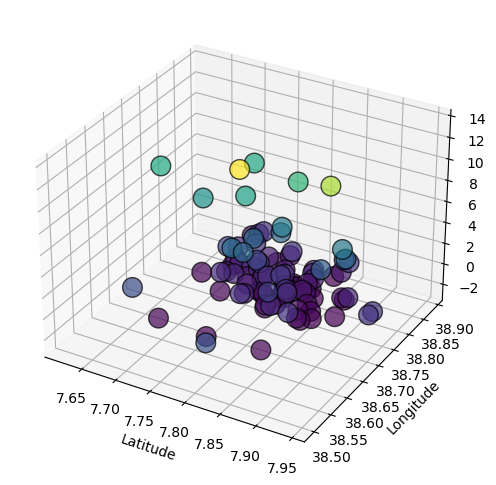

In [38]:
from mpl_toolkits.mplot3d import Axes3D

x = df_events["lat"]
y = df_events["lon"]
z = df_events["depth"]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Depth')
plt.show()

In [39]:
df_catalogue

,YYYY,MM,DD,hh,mm,ss.mmmm,MLDateNum,Lat,Lon,Dep,ErrEll,ErrX,ErrY,ErrZ,ML,MLEnRel,"Wo,m\t",Fc\t,"Mo,Nm\tMw Rad,km dSig,bar MwEnRel\tDip\tStrike",Rake
0,2012,1,10,9,52,26.3817,734878.411416,7.86449,38.8149,-1.940,738,4.34,4.23,2.96,1.525,2.440000e+11,2.580e-08,17.70,8.270e+11 1.724 0.0551 4.340e+01 4.850e+11 NaN,NaN NaN
1,2012,1,10,22,2,38.0681,734878.918496,7.81778,38.7872,6.452,10839,8.15,10.13,4.14,0.609,1.030000e+10,9.100e-10,23.02,2.420e+10 0.682 0.0465 1.030e+00 1.330e+10 NaN,NaN NaN
2,2012,1,11,0,11,15.1495,734879.007814,7.55660,38.7194,2.588,108902,19.15,19.20,9.30,1.056,4.830000e+10,1.020e-09,14.21,2.830e+10 0.897 0.0672 4.090e-01 2.790e+10 NaN,NaN NaN
3,2012,1,11,5,2,48.1591,734879.210280,7.65881,38.7396,-1.276,32656,13.39,15.65,5.31,1.884,8.430000e+11,1.810e-09,30.00,2.650e+10 0.879 0.0308 3.960e+00 2.620e+10 NaN,NaN NaN
4,2012,1,11,7,28,6.8849,734879.311191,7.71214,38.8792,2.347,405938,38.34,51.35,9.44,1.786,6.010000e+11,2.680e-09,28.70,2.910e+11 1.573 0.0333 3.460e+01 2.880e+11 NaN,NaN NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2744,2014,1,29,2,6,25.7100,735628.087798,7.86328,38.8726,8.987,556,2.30,2.54,3.55,0.777,1.840000e+10,3.160e-09,17.07,1.190e+11 1.277 0.0753 1.480e+00 1.040e+11 NaN,NaN NaN
2745,2014,1,29,11,32,29.4676,735628.480897,7.72827,38.8803,-1.879,514,4.29,1.35,3.22,1.559,2.750000e+11,1.130e-08,14.95,4.880e+11 1.661 0.0630 1.130e+01 3.900e+11 NaN,NaN NaN
2746,2014,1,30,20,47,31.0735,735629.866332,6.94240,38.4897,2.588,11907,4.59,14.65,6.20,1.723,4.840000e+11,1.600e-08,17.75,6.580e+11 1.788 0.0758 3.120e+01 6.050e+11 NaN,NaN NaN
2747,2014,1,30,22,44,54.5582,735629.947854,6.96057,38.3407,6.210,13295,9.31,10.27,4.70,1.856,7.660000e+11,2.220e-08,7.06,2.250e+12 2.057 0.1657 1.840e+00 1.530e+12 NaN,NaN NaN


In [55]:
df_test = df_catalogue.iloc[1199:1207,0:10]

In [56]:
df_test

,YYYY,MM,DD,hh,mm,ss.mmmm,MLDateNum,Lat,Lon,Dep
1199,2012,12,20,20,11,48.4713,735223.841533,7.18182,38.4209,2.467
1200,2012,12,20,20,12,33.8972,735223.842059,7.44542,38.9668,12.006
1201,2012,12,20,20,13,47.3170,735223.842909,7.17480,38.4128,7.961
1202,2012,12,20,20,15,22.2271,735223.844007,7.18137,38.4185,3.373
1203,2012,12,20,21,39,13.1734,735223.902236,7.70844,38.7963,8.504
1204,2012,12,20,22,45,26.4137,735223.948222,7.70804,38.7901,8.806
1205,2012,12,20,23,11,33.6061,735223.966361,7.72826,38.7261,10.919
1206,2012,12,20,23,13,23.9047,735223.967638,7.72268,38.6280,8.142


In [57]:
df_test.columns

Index(['YYYY ', 'MM ', 'DD ', 'hh ', 'mm ', 'ss.mmmm ', '      MLDateNum ',
       '    Lat ', '    Lon  ', '   Dep  '],
      dtype='object')

In [58]:
df_test.dtypes

YYYY                  int64
MM                    int64
DD                    int64
hh                    int64
mm                    int64
ss.mmmm             float64
      MLDateNum     float64
    Lat             float64
    Lon             float64
   Dep               object
dtype: object

In [59]:
df_test['   Dep  '] =df_test['   Dep  '].astype(float)

In [45]:
df_test.dtypes

YYYY                  int64
MM                    int64
DD                    int64
hh                    int64
mm                    int64
ss.mmmm             float64
      MLDateNum     float64
    Lat             float64
    Lon             float64
   Dep              float64
dtype: object

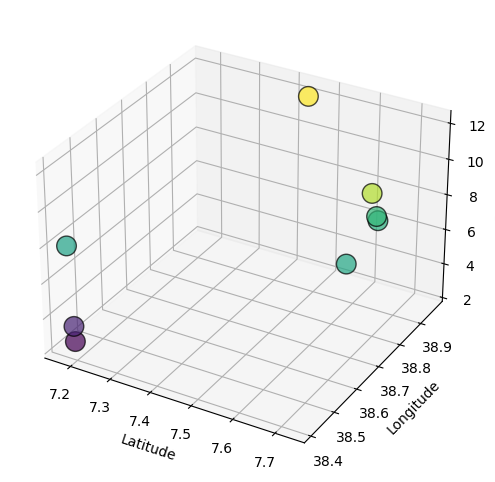

In [60]:
from mpl_toolkits.mplot3d import Axes3D

x = df_test['    Lat ']
y = df_test['    Lon  ']
z = df_test['   Dep  ']

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Depth')
plt.show()

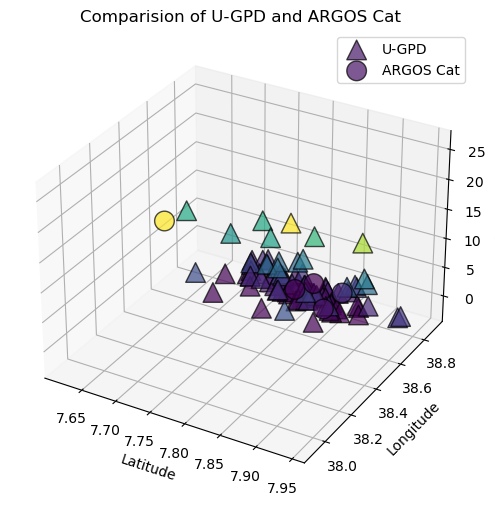

In [46]:
fig = plt.figure(figsize=(8, 6))
#fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

a = df_events["lat"]
b = df_events["lon"]
c = df_events["depth"]

x = df_test['    Lat ']
y = df_test['    Lon  ']
z = df_test['   Dep  ']


ax.scatter(a, b, c,
           linewidths=1, marker='^', alpha=.7,
           edgecolor='k',
           s = 200,
           c=c, label='U-GPD')

ax.scatter(x, y, z,
           linewidths=1, marker='o', alpha=.7,
           edgecolor='k',
           s = 200,
           c=z, label='ARGOS Cat')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Depth')
ax.set_title('Comparision of U-GPD and ARGOS Cat')
ax.legend()
plt.savefig('test.pdf')
plt.show()